## Initialize Package

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize,TweetTokenizer
from bs4 import BeautifulSoup
import re,string,unicodedata
from keras.preprocessing import text, sequence
from string import punctuation
import keras
from keras.models import Sequential
import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import tensorflow as tf
import numpy as np
import pandas as pd
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

## Load Data

In [ ]:
dtrain = pd.read_csv('gdrive/My Drive/Colab Notebooks/Corona NLP/Corona_NLP_train.csv')
dtest = pd.read_csv('gdrive/My Drive/Colab Notebooks/Corona NLP/Corona_NLP_test.csv')

In [ ]:
dtrain.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [ ]:
dtest.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


## Check missing value

In [ ]:
# check for null value in train_data
dtrain.isna().sum()

UserName            0
ScreenName          0
Location         8590
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

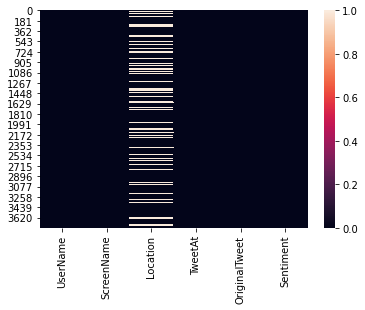

In [ ]:
sns.heatmap(dtest.isnull());

In [ ]:
dtrain.drop_duplicates(inplace= True)
dtest.drop_duplicates(inplace=True)

In [ ]:
dtrain.dropna(inplace=True)
dtest.dropna(inplace=True)
print(dtrain.isna().sum())
print("******")
print(dtest.isna().sum())

UserName         0
ScreenName       0
Location         0
TweetAt          0
OriginalTweet    0
Sentiment        0
dtype: int64
******
UserName         0
ScreenName       0
Location         0
TweetAt          0
OriginalTweet    0
Sentiment        0
dtype: int64


# EDA

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


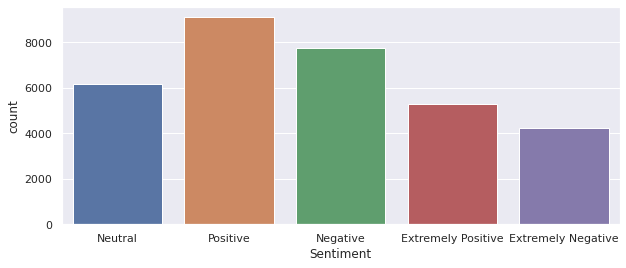

In [ ]:
sns.set(rc={'figure.figsize':(10,4)})
sns.countplot(dtrain['Sentiment'])

In [ ]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from nltk.corpus import stopwords
sw = stopwords.words('english')
np.array(sw)

# Function that cleans tweets for classification. 
def clean_tweet(tweet):
    # Remove hyperlinks.
    tweet= re.sub(r'https?://\S+|www\.\S+','',tweet)
    # Remove html
    tweet = re.sub(r'<.*?>','',tweet)
    # Remove numbers (Do we want to remove numbers? Death toll?)
    tweet = re.sub(r'\d+','',tweet)
    # Remove mentions
    tweet = re.sub(r'@\w+','',tweet)
    # Remove punctuation
    tweet = re.sub(r'[^\w\s\d]','',tweet)
    # Remove whitespace
    tweet = re.sub(r'\s+',' ',tweet).strip()
    # Remove stopwords
    tweet = " ".join([word for word in str(tweet).split() if word not in sw])
    
    return tweet.lower()

In [ ]:
# Check function
example = dtrain['OriginalTweet'][1]
clean_tweet(example)

'advice talk neighbours family exchange phone numbers create contact list phone numbers neighbours schools employer chemist gp set online shopping accounts poss adequate supplies regular meds order'

In [ ]:
dtrain['newTweet'] = dtrain['OriginalTweet'].apply(lambda x: clean_tweet(x))
dtest['newTweet'] = dtest['OriginalTweet'].apply(lambda x: clean_tweet(x))

In [ ]:
encoding = {'Extremely Negative': 0,
            'Negative': 0,
            'Neutral': 1,
            'Positive':2,
            'Extremely Positive': 2
           }

labels = ['Negative', 'Neutral', 'Positive']
           

dtrain.replace(encoding, inplace=True)
dtest.replace(encoding, inplace=True)

In [ ]:
dtrain.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,newTweet
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,1,
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,2,advice talk neighbours family exchange phone n...
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,2,coronavirus australia woolworths give elderly ...
5,3804,48756,"ÃœT: 36.319708,-82.363649",16-03-2020,As news of the regionÂ’s first confirmed COVID...,2,as news regionâs first confirmed covid case ca...
6,3805,48757,"35.926541,-78.753267",16-03-2020,Cashier at grocery store was sharing his insig...,2,cashier grocery store sharing insights covid_ ...


In [ ]:
def token_lemma(tweet):
    tk = TweetTokenizer()
    lemma = WordNetLemmatizer()
    tweet = tk.tokenize(tweet)
    tweet = [lemma.lemmatize(word) for word in tweet]
    tweet = " ".join([word for word in tweet])
    return tweet

In [ ]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
def token_stem(tweet):
    tk = TweetTokenizer()
    stemmer = PorterStemmer()
    tweet = tk.tokenize(tweet)
    tweet = [stemmer.stem(word) for word in tweet]
    tweet =  tweet = " ".join([word for word in tweet])
    return tweet

In [ ]:
dtrain['stemTweet'] = dtrain['newTweet'].apply(lambda x: token_stem(x))
dtrain['lemmaTweet'] = dtrain['newTweet'].apply(lambda x: token_lemma(x))
dtrain.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,newTweet,stemTweet,lemmaTweet
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,1,,,
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,2,advice talk neighbours family exchange phone n...,advic talk neighbour famili exchang phone numb...,advice talk neighbour family exchange phone nu...
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,2,coronavirus australia woolworths give elderly ...,coronaviru australia woolworth give elderli di...,coronavirus australia woolworth give elderly d...
5,3804,48756,"ÃœT: 36.319708,-82.363649",16-03-2020,As news of the regionÂ’s first confirmed COVID...,2,as news regionâs first confirmed covid case ca...,as news regionâ first confirm covid case came ...,a news regionâs first confirmed covid case cam...
6,3805,48757,"35.926541,-78.753267",16-03-2020,Cashier at grocery store was sharing his insig...,2,cashier grocery store sharing insights covid_ ...,cashier groceri store share insight covid _ to...,cashier grocery store sharing insight covid _ ...


In [ ]:
dtest['stemTweet'] = dtest['newTweet'].apply(lambda x: token_stem(x))
dtest['lemmaTweet'] = dtest['newTweet'].apply(lambda x: token_lemma(x))
dtest.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,newTweet,stemTweet,lemmaTweet
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,0,trending new yorkers encounter empty supermark...,trend new yorker encount empti supermarket she...,trending new yorkers encounter empty supermark...
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,2,when i couldnt find hand sanitizer fred meyer ...,when i couldnt find hand sanit fred meyer i tu...,when i couldnt find hand sanitizer fred meyer ...
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,0,panic buying hits newyork city anxious shopper...,panic buy hit newyork citi anxiou shopper stoc...,panic buying hit newyork city anxious shopper ...
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,1,toiletpaper dunnypaper coronavirus coronavirus...,toiletpap dunnypap coronaviru coronavirusaustr...,toiletpaper dunnypaper coronavirus coronavirus...
5,6,44958,Los Angeles,03-03-2020,Do you remember the last time you paid $2.99 a...,1,do remember last time paid gallon regular gas ...,do rememb last time paid gallon regular ga lo ...,do remember last time paid gallon regular gas ...


In [ ]:
#img = Image.open(data_dict['rona4.jpeg'])
mask = np.array(Image.open('rona4.jpeg'))

# Positive WordCloud
pos_df = dtrain[dtrain['Sentiment'] == 2]
pos_text = pos_df['lemmaTweet'].to_string(index = False)
pos_text = re.sub(r'\n','',pos_text)
pos_cloud = WordCloud(colormap = 'Set2', mask = mask).generate(pos_text)

# Neutral WordCloud
neut_df = dtrain[dtrain['Sentiment'] == 1]
neut_text = neut_df['lemmaTweet'].to_string(index = False)
neut_text = re.sub(r'\n','', neut_text)
neut_cloud = WordCloud(colormap = 'Pastel1', mask = mask).generate(neut_text)

# Negative wordcloud
neg_df = dtrain[dtrain['Sentiment'] == 0]
neg_text = neg_df['lemmaTweet'].to_string(index = False)
neg_text = re.sub(r'\n','', neg_text)
neg_cloud = WordCloud(colormap = 'Set2', mask = mask).generate(neg_text)

(-0.5, 473.5, 473.5, -0.5)

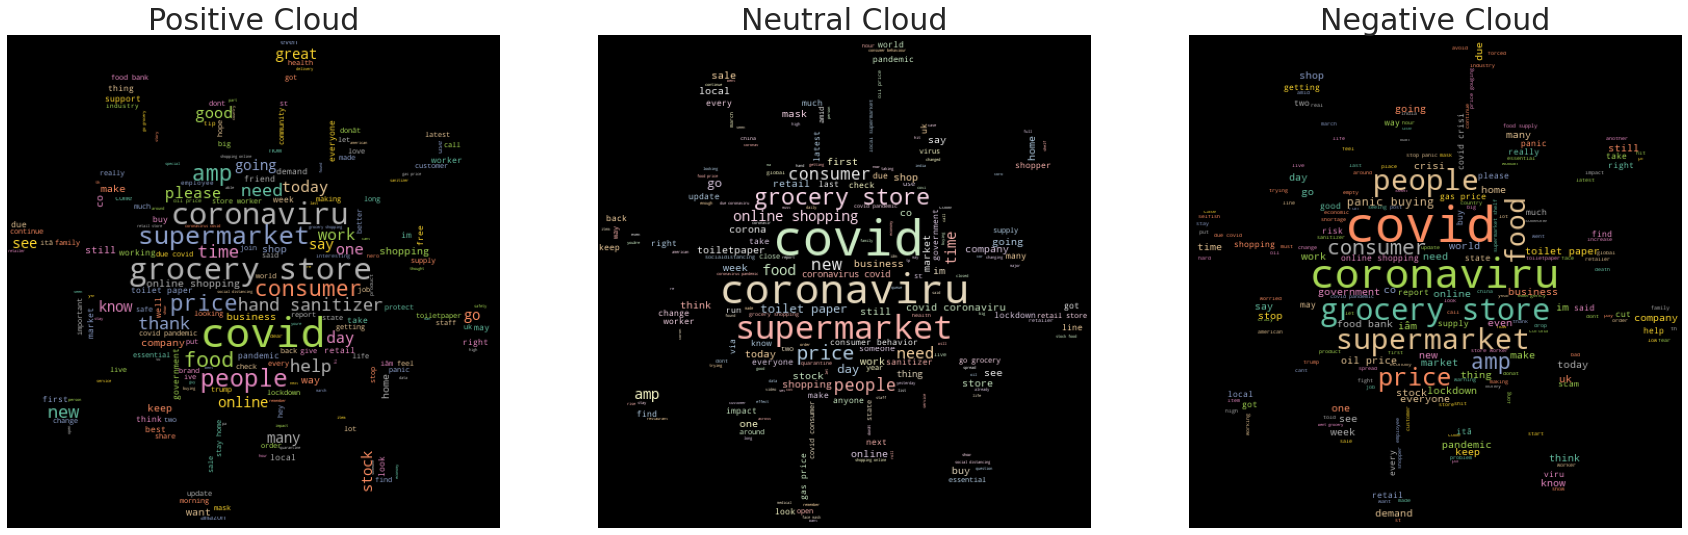

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = [30,20])
ax1.imshow(pos_cloud)
ax1.set_title('Positive Cloud', fontsize = 30)
ax1.axis('off')
ax2.imshow(neut_cloud)
ax2.set_title('Neutral Cloud', fontsize = 30)
ax2.axis('off')
ax3.imshow(neg_cloud)
ax3.set_title('Negative Cloud', fontsize = 30)
ax3.axis('off')